# Рынок заведений общественного питания Москвы

# Содержание

- Шаг 1. Загрузим данные и подготовим их к анализу
- Шаг 2. Анализ данных
- Шаг 3. Общий вывод
- Шаг 4. Рекомендации

# Шаг 1. Загрузим данные и подготовим их к анализу

In [33]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime as dt
import datetime
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 100
import plotly.express as px
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

In [10]:
try:
    rest_data = pd.read_csv('rest_data.csv', sep=',')
except:
    rest_data = pd.read_csv('/datasets/rest_data.csv', sep=',')

In [11]:
df_list = [rest_data]
for df in df_list:
    print('Первые 5 строк')
    print('-'*50)
    display(df.head())
    print('-'*50)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('-'*50)
    print('Типы данных и общая информация')
    print(df.info())
    print('-'*50)
    print('Наличие дубликатов: {}'.format(df.duplicated().sum()))
    print('-'*50)
    print('Наличие пропусков')
    print('-'*50)
    print(df.isna().sum())
    print('Стат данные')
    print('-'*50)
    display(df.describe())

Первые 5 строк
--------------------------------------------------


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


--------------------------------------------------
Размер датафрейма: (строк:столбцов) (15366, 6)
--------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None
--------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------
Наличие пропусков
--------------------------------------------------
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64
Стат данные
-------

,id,number
count,"15,366.00","15,366.00"
mean,"119,720.07",59.55
std,"73,036.13",74.74
min,838.00,0.00
25%,"28,524.00",12.00
50%,"144,974.50",40.00
75%,"184,262.25",80.00
max,"223,439.00","1,700.00"


-  Дубликатов и аномальных значений нет, на первый взгляд данные достаточно чистые.

# Шаг №2. Анализ данных

Исследуем соотношение видов объектов общественного питания по количеству:

In [12]:
rest_data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [13]:
object_types = rest_data.groupby('object_type', as_index=False).agg({'object_name':'count'}).sort_values(by='object_name', ascending=False)
object_types['percent'] = (object_types['object_name']/object_types['object_name'].sum()*100).round(1).astype('str') + '%'
fig = px.bar(object_types, y='object_name', x='object_type', text='object_name', color='object_type', width=900, height=550)
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Соотношение видов объектов общественного питания по количеству',
    xaxis_title="Тип объекта",
    yaxis_title="Количество")
fig.update_traces(textposition='outside')
# texttemplate='%{text:.2%}', 
for trace, percent in zip(fig.data,object_types['percent']) :
    trace.name = trace.name.split('=')[0] + ' (' + percent+ ')'
fig.show()

-  Наиболее массовым объектом общественного питания является Кафе (39,7%).

Исследуем соотношение сетевых и несетевых заведений по количеству:

In [14]:
rest_data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [15]:
fig = go.Figure(data=go.Pie(labels=rest_data['chain'].value_counts().reset_index()['index'], values=rest_data['chain'].value_counts()))
fig.update_layout(
    title={
        'text':'Соотношение сетевых и несетевых заведений по количеству',
        'y':0.9,
        'x':0.48})
for trace in fig.data:
    trace['labels']=['Несетевые', 'Сетевые']
fig.show()

-  В исследуемых данных, только 19.3% заведений имеют доставку.

Посмотрим для какого вида объекта общественного питания характерно сетевое распространение:

In [16]:
rest_chain = rest_data.groupby('object_type')['chain'].value_counts(normalize=True)

In [17]:
object_type = [
    'кафе',
    'столовая',
    'ресторан',
    'предприятие быстрого обслуживания',
    'бар',
    'буфет',
    'кафетерий',
    'закусочная',
    'отдел кулинарии',
]
values = [0.228890, 0.001160, 0.238074, 0.411336, 0.043224,0.018803,0.130653,0.155556,0.285714]

fig = go.Figure()
fig.update_layout(
    title={
        'text':'Сетевое распостранение объектов общественного питания',
        'y':0.9,
        'x':0.48})
fig.add_trace(go.Pie(values=values, labels=object_type))
fig.show() 

In [18]:
object_chain = (rest_data
                .groupby(['object_type','chain'])['id'].count()
                .reset_index()
                .rename(columns={'id':'counts'})
                .merge(rest_data.groupby('object_type').chain.count(), on='object_type',suffixes=('','_total'))
               )

In [19]:
object_chain['ratio_percent'] = round((object_chain.counts / object_chain.chain_total) * 100)

In [20]:
fig = px.bar(object_chain,title='Для какого вида объекта общественного питания характерно сетевое распространение', x='object_type', y='counts', color='chain')
fig.update_xaxes(tickangle=45)
fig.show()

-  Сетевое распространение наиболее характерно для:
-  Предприятий быстрого обслуживания (41%)
-  Отделов кулинарии магазинов (29%)
-  Ресторанов (24%)
-  Кафе (23%)  

Посмотрим,что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.

In [21]:
onlain_rest = rest_data[rest_data['chain'] == 'да']

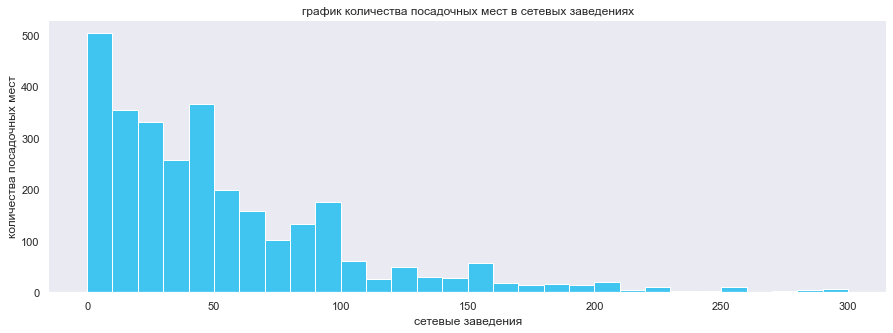

In [22]:
plt.figure(figsize=(15, 5))
onlain_rest['number'].hist(bins=30, range=(0,300), grid=False, color='#3fc5f0')
sns.despine(left=True)
plt.title('график количества посадочных мест в сетевых заведениях')
plt.xlabel('сетевые заведения')
plt.ylabel('количества посадочных мест')
plt.show()

-  Для сетевых заведений наиболее характерно много заведений с небольшим числом посадочных мест в каждом (до 50 посадочных мест)

Для каждого вида объекта общественного питания опишем среднее количество посадочных мест и посмотрим, какой вид предоставляет в среднем самое большое количество посадочных мест. Построим график.

In [23]:
pd.pivot_table(rest_data,
               index=["object_type"],
               values=["number"],
               aggfunc=[np.mean])

,mean
,number
object_type,
бар,43.49
буфет,51.13
закусочная,7.61
кафе,39.72
кафетерий,9.12
магазин (отдел кулинарии),5.59
предприятие быстрого обслуживания,20.55
ресторан,96.83


In [24]:
object_type = [
    'кафе',
    'столовая',
    'ресторан',
    'предприятие быстрого обслуживания',
    'бар',
    'буфет',
    'кафетерий',
    'закусочная',
    'отдел кулинарии',
]
values = [39.72, 130.25, 96.83, 20.55, 43.49,51.13,9.12,7.61,5.59]

fig = go.Figure()
fig.update_layout(
    title={
        'text':'Среднее количество посадочных мест в объектах общественного питания',
        'y':0.9,
        'x':0.48})
fig.add_trace(go.Pie(values=values, labels=object_type))
fig.show() 

- Наибольшое количество посадочных мест в среднем:
- Столовые - 130,25
- Рестораны - 96,83
- Буфеты - 51.13  

In [25]:
street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 
'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']
def street_finder(address):
    for address_part in address.split(', '):
        for street_type in street_types:
            if address_part.lower().find(street_type)!= -1:
                return address_part

rest_data['street'] = rest_data['address'].apply(street_finder)
data_with_streets = rest_data[~(rest_data['street'].isnull())]

In [26]:
print('После выделения улиц из адреса, у нас осталось 382 адреса, в которых не указана улица ЯВНО.\n'
     'Как правило, это поселки и другие загородные адреса. Мы далее не будем использовать такие строки в данных.\n'
     'Мы сохранили датафрейм только с ЯВНЫМИ названиями улиц для дальнейшей работы с улицами. Ниже он.')
data_with_streets.head(5)

После выделения улиц из адреса, у нас осталось 382 адреса, в которых не указана улица ЯВНО.
Как правило, это поселки и другие загородные адреса. Мы далее не будем использовать такие строки в данных.
Мы сохранили датафрейм только с ЯВНЫМИ названиями улиц для дальнейшей работы с улицами. Ниже он.


,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Построим график топ-10 улиц по количеству объектов общественного питания:

In [27]:
top_streets = data_with_streets.groupby('street', as_index=False).agg({'object_name':'count'})
top_streets.columns = ['street', 'objects']
top_streets = top_streets.sort_values(by='objects', ascending = False)
top10_streets = top_streets.head(10)
print('Топ-10 улиц с наибольшим количеством заведений:\n', top10_streets)

Топ-10 улиц с наибольшим количеством заведений:
                       street  objects
1426           проспект Мира      204
1014       Профсоюзная улица      183
686   Ленинградский проспект      173
997   Пресненская набережная      167
399         Варшавское шоссе      165
689       Ленинский проспект      148
1422    проспект Вернадского      132
676     Кутузовский проспект      114
599          Каширское шоссе      112
606     Кировоградская улица      110


In [28]:
fig = px.bar(top10_streets, x='street', y='objects', 
             color='street', width = 900, height = 550, text='objects')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title='Топ-10 улиц с наибольшим количеством заведений',
    xaxis_title="Улица",
    yaxis_title="Количество заведений")
for trace in fig.data:
    trace.name = trace.name.split('=')[0]
fig.show()

Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы:

https://docs.google.com/spreadsheets/d/e/2PACX-1vTfCX6ZrY-GPe6TI46AVgovNy7EZgrTkejvFIvfpCfK5ZC53r86IIWZ_76rjp6RGoDyCtLFgLEZwYhY/pub?output=csv

In [29]:
pathtoCsv = r'https://docs.google.com/spreadsheets/d/e/2PACX-1vTfCX6ZrY-GPe6TI46AVgovNy7EZgrTkejvFIvfpCfK5ZC53r86IIWZ_76rjp6RGoDyCtLFgLEZwYhY/pub?output=csv'
district = pd.read_csv(pathtoCsv)

In [30]:
display(district)

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [34]:
top10_streets_merged = top10_streets.merge(district[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname')
streets = pd.DataFrame(data=top10_streets_merged['street'].unique(), columns=['street'])

def areas(row, data):
    result = data[data['street']==row['street']]['area'].to_list()
    return result
top10_streets['areas'] = top10_streets.apply(areas, args=[top10_streets_merged], axis=1)
print('\n')
for street, areas in zip(top10_streets['street'], top10_streets['areas']):
    print('{} находится в:'.format(street))   
    for area in areas:
        numeric=1
        print('-', area)
    print('') 



проспект Мира находится в:
- Алексеевский район
- Ярославский Район
- Район Марьина роща
- Останкинский район
- Район Ростокино
- Район Свиблово
- Мещанский район

Профсоюзная улица находится в:
- Академический район
- Район Черемушки
- Район Ясенево
- Район Коньково
- Обручевский район
- Район Теплый Стан

Ленинградский проспект находится в:
- Район Аэропорт
- Район Беговой
- Хорошевский район
- Район Сокол

Пресненская набережная находится в:
- Пресненский район

Варшавское шоссе находится в:
- Район Чертаново Центральное
- Район Чертаново Северное
- Район Чертаново Южное
- Донской район
- Район Нагатино-Садовники
- Нагорный район
- Район Северное Бутово
- Район Южное Бутово

Ленинский проспект находится в:
- Район Проспект Вернадского
- Район Тропарево-Никулино
- Донской район
- Район Гагаринский
- Ломоносовский район
- Обручевский район
- Район Теплый Стан
- Район Якиманка

проспект Вернадского находится в:
- Район Проспект Вернадского
- Район Раменки
- Район Тропарево-Никулино
-

In [32]:
areas_top10_streets_pivot = top10_streets_merged.groupby('street', as_index=False).agg({'objects':'mean', 'okrug':'nunique', 'area':'nunique'})
areas_top10_streets_pivot.columns = ['', 'Объектов', 'Округов', 'Районов']
areas_top10_streets_pivot = areas_top10_streets_pivot.set_index('')
areas_top10_streets_pivot.loc[''] = ''
areas_top10_streets_pivot.loc['В среднем'] = areas_top10_streets_pivot[:-1].mean()
areas_top10_streets_pivot

,Объектов,Округов,Районов
,,,
Варшавское шоссе,165.00,2,8
Каширское шоссе,112.00,1,4
Кировоградская улица,110.00,1,3
Кутузовский проспект,114.00,1,2
Ленинградский проспект,173.00,1,4
Ленинский проспект,148.00,4,8
Пресненская набережная,167.00,1,1
Профсоюзная улица,183.00,1,6
проспект Вернадского,132.00,2,5


Найдем число улиц с одним объектом общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы:

In [35]:
streets_with_1_object = top_streets[top_streets['objects']==1]
print('Всего улиц с 1 объектом общественного питания: {}, что составляет {:.1%} от всего кол-ва улиц с объектами общественного питания'\
      .format(len(streets_with_1_object), (len(streets_with_1_object)/len(top_streets))))

streets_with_1_object_merged = streets_with_1_object.merge(district[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname')
# streets = pd.DataFrame(data=top10_streets_merged['street'].unique(), columns=['street'])

def areas(row, data):
    result = data[data['street']==row['street']]['area'].to_list()
    return result
streets_with_1_object['areas'] = streets_with_1_object.apply(areas, args=[streets_with_1_object_merged], axis=1)
print('\n')

print('Районы, в которых находятся улицы с 1 объектом общественного питания:')
for area in streets_with_1_object_merged['area'].sort_values().unique():
    print('-', area)

Всего улиц с 1 объектом общественного питания: 551, что составляет 28.9% от всего кол-ва улиц с объектами общественного питания


Районы, в которых находятся улицы с 1 объектом общественного питания:
- Алексеевский район
- Алтуфьевский район
- Бабушкинский район
- Басманный район
- Бескудниковский Район
- Бутырский район
- Войковский Район
- Головинский район
- Даниловский район
- Дмитровский район
- Донской район
- Красносельский район
- Лосиноостровский район
- Мещанский район
- Можайский Район
- Молжаниновский район
- Нагорный район
- Нижегородский район
- Обручевский район
- Останкинский район
- Панфиловский район
- Пресненский район
- Район Арбат
- Район Аэропорт
- Район Беговой
- Район Бирюлево Восточное
- Район Богородское
- Район Внуково
- Район Восточное Измайлово
- Район Восточный
- Район Выхино-Жулебино
- Район Гагаринский
- Район Гольяново
- Район Дорогомилово
- Район Замоскворечье
- Район Западное Дегунино
- Район Зюзино
- Район Ивановское
- Район Измайлово
- Район Коньков

Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Подумаем, какие закономерности можно выявить.

In [36]:
top10_streets_list = top10_streets['street'].to_list()
top10_streets_data = rest_data.query('street in @top10_streets_list')

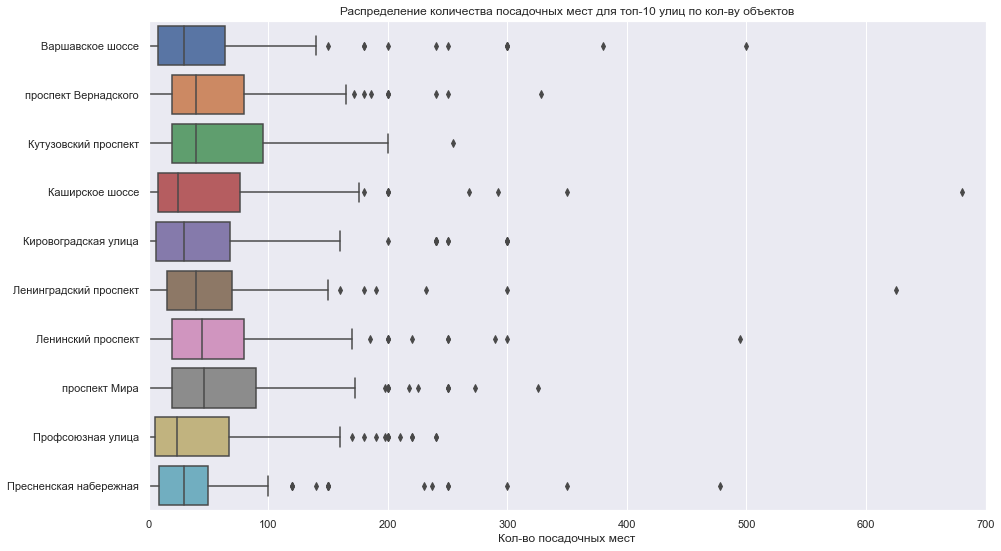

In [37]:
top10_streets_data['number'].median()
rest_data['number'].median()
plt.figure(figsize=(15,9))
plt.xlim(0,700)
sns.boxplot(data=top10_streets_data, x='number', y='street')
plt.title('Распределение количества посадочных мест для топ-10 улиц по кол-ву объектов')
plt.ylabel('')
plt.xlabel('Кол-во посадочных мест')
plt.show()

In [38]:
print('Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: {}'.format(top10_streets_data['number'].median()))
print('Среднее кол-во посадочных мест в заведениях НЕ на топ-10 улицах по количеству объектов: {}'\
.format(rest_data.query('street not in @top10_streets_list')['number'].median()))

Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: 38.5
Среднее кол-во посадочных мест в заведениях НЕ на топ-10 улицах по количеству объектов: 40.0


In [39]:
print('\nПроверим, значима ли статистически разница между кол-вами посадочных мест'
'\nв заведениях на топ-10 улицах и остальных.')
print('Используем тест Стъюдента.')
print('Нулевой гипотезой будет гипотеза о равенстве количества посадочных мест на топ-10 улицах по'
'\nколичеству объектов и на остальных улицах.')
alpha=0.05

results = stats.ttest_ind(rest_data.query('street not in @top10_streets_list')['number'],
                            top10_streets_data['number'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, разница между количествами посадочных мест статистически ЗНАЧИМА.')
else:
    print('Не отвергаем нулевую гипотезу. Разницы между количествами посадочных мест НЕТ.')


Проверим, значима ли статистически разница между кол-вами посадочных мест
в заведениях на топ-10 улицах и остальных.
Используем тест Стъюдента.
Нулевой гипотезой будет гипотеза о равенстве количества посадочных мест на топ-10 улицах по
количеству объектов и на остальных улицах.
P-value: 0.3868435747276817
Не отвергаем нулевую гипотезу. Разницы между количествами посадочных мест НЕТ.


# Шаг 3. Общий вывод

- Мы выяснили, что наибольшее количество типов объектов общественного притания составляют кафе 40%, столовые 17%, рестораны 15%, фастфуды 12,5% и бары 6%.    
- При этом сетевых заведений лишь 20% от общего количества, остальные - несетевые.
- Сетевое распространение характерно для предприятий быстрого обслуживания (41% заведений данного типа). В меньше мере оно характерно для магазинов (29% заведений), ресторанов (24% заведений) и кафе (23% заведений).
- Для сетевых заведений наиболее характерно много заведений с небольшим числом посадочных мест в каждом (до 50 посадочных мест).
- Среднее количество посадочных мест по типам объектов общественного питания:
- столовая 130
- ресторан 97
- буфет 51
- бар 43
- кафе 39 
    
-  Топ-10 улиц с наибольшим количеством заведений:
- проспект Мира 204
- Профсоюзная улица 183
- Ленинградский проспект 173
- Пресненская набережная 167
- Варшавское шоссе 165
- Ленинский проспект 148
- проспект Вернадского 132
- Кутузовский проспект 114
- Каширское шоссе 112
- Кировоградская улица 110.
    
- Так же у нас есть список районов, в которых располагаются топ-10 улиц по кол-ву объектов общественного питания. Всего улиц с одним объектом общественного питания: 551, что составляет 28.9% от всего кол-ва улиц с объектами общественного питания в Москве. Список районов мы так же можем предоставить, в которых располагаются данные улицы.

- Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: 38.5 Среднее кол-во посадочных мест в заведениях НЕ на топ-10 улицах по количеству объектов: 40.0

- Проверили, значима ли статистически разница между кол-вами посадочных мест в заведениях на топ-10 улицах и остальных. Нулевой гипотезой считали гипотезу о равенстве количества посадочных мест. Полученный p-value: 0.3868435747276817 Нулевую гипотезу мы не смогли отвергнуть. Это означает, что разницы между количествами посадочных мест НЕТ. 

# Шаг 4. Рекомендации

- Сложно дать какие-то рекомендации без обратной связи и большей информации от инвесторов и учредителей. Можно отталкиваться от того, что на рынке более популярны кафе (предполагаем, что раз их больше, то они более популярны, но не факт), потому именно такой тип заведения и рекомендовать со средним количеством посадочных мест на 30 персон. Касаемо района и улиц, то предполагаем что объект лучше размещать на одной из топ-10 улиц, ведь не спроста на этих улицах наибольшее количество объектов. Но эта логика тоже не совсем точна, так как все-таки самое важное - это проходимость объекта, преобладающая каста людей в радиусе в зависимости от портрета клиента.
- Если учитывать не только предоставленные данные, то конечно заведение, должно быть сетевым.
- Наше исследование получилось очень поверхностным. Если бы мы использовали api яндекс геокодера, то смогли бы расположить все заведения на карте и общая картина была бы видна лучше. Плюс надо было бы обратить внимание на перспективные районы с малым количеством заведений на текущий момент. Необходимо было бы провести анализ по расположению мест скопления большого количества людей, кто регулярно покупает бизнес-ланчи - ВУЗы, крупные предприятия, бизнес-центры. Желательно учитывать по текущим объектам расстояния до метро, какое метро, средние чеки в заведениях. (посмотреть зависимость среднего чека от типов объекта, расстояния от метро, расположениях в топовых районах). Так же желательно выделить наиболеее интересные здания для размещения заведений - высотки, исторические здания, топовые отели и гостиницы. Плюс желательно подумать об иностранных туристах заранее, ведь можно примерно сказать, где они проводят большую часть времени в Москве.